In [3]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import os, sys, glob
import matplotlib.pyplot as plt
import seaborn as sns
import utils, config
import scprep, phate
import matplotlib.pyplot as plt
import matplotlib as mpl
import embedding_helpers as mf
import matplotlib.patches as patches
import scipy.stats as stats
import statistics_helpers as mystats

## colormaps from lightest to darkest
evis_colors = ["#FFFFFF","#E9B0D2", "#DE88BC", "#D360A5", "#AF4F88"]
hvis_colors = ["#FFFFFF","#CCB2D5", "#B28BC0","#9864AB","#7D538D"]
aud_colors = ["#FFFFFF",'#D1F0F2','#A2E1E4',"#44C2C9","#38A0A6"]
pmc_colors = ["#FFFFFF","#B1DFB1","#8DD18D","#58BB58","#499B49"]
big_colors = ["#AF4F88", "#7D538D", "#38A0A6", "#499B49"]

colors_dict = {'voxel':0, 'PCA':1, 'UMAP':2, "PHATE":3, "TPHATE":4, "PHATE_TIME":1, "SMOOTH_PHATE":3, 
              "ISOMAP":1, "LLE":2, "TSNE":3}

evis_3colors = ["#E9B0D2", "#DE88BC", "#AF4F88"]
hvis_3colors = ["#CCB2D5", "#B28BC0","#7D538D"]
aud_3colors = ['#D1F0F2','#A2E1E4',"#38A0A6"]
pmc_3colors = ["#B1DFB1","#8DD18D","#499B49"]

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import utils

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


In [2]:
def barplot_all_methods(dataframe, dataset, yname, outfn, methods, 
                        method_label=None, ylabel=None, ROIs=None, ylim=None, 
                        logscale=False, yax=False, figsize=(6,6), draw_signif=True):
    if not ylabel:
        ylabel = yname
    if not ROIs:
        ROIs=config.ROIs
    if not method_label:
        method_label = 'embed_method'
    
    COLOR_IDX = sorted([colors_dict[method] for method in methods])
    ROI_codes = {'early_visual':'EV', 'high_Visual':"HV", 'aud_early':"EA", 'pmc_nn':'PMC'}
    X_LABELS = [ROI_codes[r] for r in ROIs]
    df = dataframe[(dataframe['dataset']==dataset) & (dataframe[method_label].isin(methods)) & (dataframe['ROI'].isin(ROIs))]
    fig,ax=plt.subplots(figsize=figsize, dpi=100)

    sns.set(style='white')
    g=sns.barplot(data=df,  x='ROI', y=yname,
                hue=method_label, ci=95., n_boot=1000,  edgecolor=big_colors,
                hue_order=methods,order=ROIs, ax=ax)
    ax.get_legend().remove()
    if dataset == 'sherlock':
        title="$\it{Sherlock}$ movie dataset"
    else:
        title="$\it{StudyForrest}$ movie dataset"
    
    g.set(xlabel='', ylabel=ylabel, title=title)
    g.set_xticklabels(X_LABELS, fontsize=16)
    
    if ylim != None and len(ylim)>2:
        g.set(yticks=ylim)
    else:
        g.set(ylim=ylim)
        
    if logscale:
        ax.set_yscale('log')
    if yax:
        ax.axhline(0, color='k', linestyle='--')

    colors_in_order = []
    edge_colors = []
    embd_roi = []
    COLORMAPS = {'EV': [evis_colors[r] for r in COLOR_IDX],
                'HV': [hvis_colors[r] for r in COLOR_IDX],
                'EA': [aud_colors[r] for r in COLOR_IDX], 
                'PMC':[pmc_colors[r] for r in COLOR_IDX]}
    
    COLORMAPS=[COLORMAPS[X] for X in X_LABELS]
    for i in range(len(COLOR_IDX)):
        for j, cmap in enumerate(COLORMAPS):
            colors_in_order.append(cmap[i])
            edge_colors.append(cmap[-1])
            embd_roi.append([methods[i], ROIs[j]])
    
    i = 0
    for container in g.containers:    
        for c, patch in enumerate(container):
            patch.set_color(colors_in_order[i])
            patch.set_edgecolor(edge_colors[i])
            i+=1
    sns.despine(top=True, right=True)
    
    # if ylim[0] < 0 and 0 < ylim[1]:
    #     ax.axhline(0, color='k', linestyle='--')
            

    if outfn is not None:
        plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')
        plt.clf()
    else:
        return fig
    

## between subj HMM results

In [4]:
df = pd.read_csv("../results/between_sub_neural_event_WB_tempBalance_results.csv",index_col=0)

In [5]:
## supplemental methods
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

for dataset in ['sherlock', 'forrest']:
    yname = 'avg_diff'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yname}_between_subj_hmm_supp.pdf'
    # barplot_all_methods(df_here, dataset, yname, fn, 
    #                     ["ISOMAP",'LLE','TSNE','TPHATE'], 
    #                     ROIs=ROIs_here, 
    #                     logscale=logsc, 
    #                     ylim=[-0.01, 0.08], 
    #                     yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 3
        for other_method in ["ISOMAP",'LLE','TSNE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
#stats_df.to_csv("../results/between_subj_HMM_stats_SUPP.csv")

failed early_visual sherlock ISOMAP avg_diff
failed early_visual sherlock LLE avg_diff
failed early_visual sherlock TSNE avg_diff
failed high_Visual sherlock ISOMAP avg_diff
failed high_Visual sherlock LLE avg_diff
failed high_Visual sherlock TSNE avg_diff
failed aud_early sherlock ISOMAP avg_diff
failed aud_early sherlock LLE avg_diff
failed aud_early sherlock TSNE avg_diff
failed pmc_nn sherlock ISOMAP avg_diff
failed pmc_nn sherlock LLE avg_diff
failed pmc_nn sherlock TSNE avg_diff
failed early_visual forrest ISOMAP avg_diff
failed early_visual forrest LLE avg_diff
failed early_visual forrest TSNE avg_diff
failed high_Visual forrest ISOMAP avg_diff
failed high_Visual forrest LLE avg_diff
failed high_Visual forrest TSNE avg_diff
failed aud_early forrest ISOMAP avg_diff
failed aud_early forrest LLE avg_diff
failed aud_early forrest TSNE avg_diff
failed pmc_nn forrest ISOMAP avg_diff
failed pmc_nn forrest LLE avg_diff
failed pmc_nn forrest TSNE avg_diff


In [6]:
## supplemental methods
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

for dataset in ['sherlock', 'forrest']:
    yname = 'avg_diff'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yname}_between_subj_hmm_supp_time.pdf'
    barplot_all_methods(df_here, dataset, yname, fn, 
                        ["PHATE_TIME",'SMOOTH_PHATE','TPHATE'], 
                        ROIs=ROIs_here, 
                        logscale=logsc, 
                        ylim=[-0.01, 0.08], 
                        yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 2
        for other_method in ["PHATE_TIME",'SMOOTH_PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
stats_df.to_csv("../results/between_subj_HMM_stats_SUPP_TIME.csv")

NameError: name 'barplot_all_methods' is not defined

In [ ]:
df = pd.read_csv("../results_final/SVC_movie_features_results.csv", index_col=0)

feat = 'MusicPresent'
d = 'sherlock'
methods = ['PCA','UMAP','PHATE','TPHATE']
d1 = df[(df['embed_method'].isin(methods)) & (df['regressor']==feat)]
ylabel='zstat'
method_label = 'embed_method'
ROIs=None
if not ylabel:
    ylabel = yname
if not ROIs:
    ROIs=config.ROIs
if not method_label:
    method_label = 'embed_method'

COLOR_IDX = sorted([colors_dict[method] for method in methods])
ROI_codes = {'early_visual':'EV', 'high_Visual':"HV", 'aud_early':"EA", 'pmc_nn':'PMC'}
X_LABELS = [ROI_codes[r] for r in ROIs]
fig,ax=plt.subplots(figsize=(5,5), dpi=100)
g = sns.violinplot(data=d1,  x='ROI', y='zstat',
                hue='embed_method', 
                hue_order=methods,order=ROIs, ax=ax)
ax.get_legend().remove()

i = 0
for container, METHOD in zip(g.containers, methods):    
    for c, patch in enumerate(container):
        x, y = patch.xy
        r = ROIs[c] 
        points = d1[(d1['embed_method']==METHOD) & (d1['ROI']==r)]['zstat'].values
        
        #ax.scatter(x=np.repeat(x+0.1, len(points)), y=points, edgecolors='k', zorder=10, linewidths=1, s=2, c='white')
        




In [10]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

for dataset in ['sherlock', 'forrest']:
    yname = 'avg_diff'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yaname}_between_subj_hmm.pdf'
    # barplot_all_methods(df_here, dataset, yname, fn, 
    #                     ['voxel','PCA','UMAP','PHATE','TPHATE'], 
    #                     ROIs=ROIs_here, 
    #                     logscale=logsc, 
    #                     ylim=[-0.01, 0.08], 
    #                     yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 4
        for other_method in ['voxel','PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
#stats_df.to_csv("../results/between_subj_HMM_stats.csv")

early_visual sherlock voxel avg_diff pc=0.004 pu=0.001
early_visual sherlock PCA avg_diff pc=0.004 pu=0.001
early_visual sherlock UMAP avg_diff pc=0.004 pu=0.001
early_visual sherlock PHATE avg_diff pc=0.004 pu=0.001
high_Visual sherlock voxel avg_diff pc=0.02 pu=0.005
high_Visual sherlock PCA avg_diff pc=0.032 pu=0.008
high_Visual sherlock UMAP avg_diff pc=0.012 pu=0.003
high_Visual sherlock PHATE avg_diff pc=0.308 pu=0.077
aud_early sherlock voxel avg_diff pc=0.004 pu=0.001
aud_early sherlock PCA avg_diff pc=0.044 pu=0.011
aud_early sherlock UMAP avg_diff pc=0.008 pu=0.002
aud_early sherlock PHATE avg_diff pc=1.027 pu=0.257
pmc_nn sherlock voxel avg_diff pc=0.004 pu=0.001
pmc_nn sherlock PCA avg_diff pc=0.004 pu=0.001
pmc_nn sherlock UMAP avg_diff pc=0.004 pu=0.001
pmc_nn sherlock PHATE avg_diff pc=0.004 pu=0.001
early_visual forrest voxel avg_diff pc=0.004 pu=0.001
early_visual forrest PCA avg_diff pc=0.004 pu=0.001
early_visual forrest UMAP avg_diff pc=0.004 pu=0.001
early_visual f

### movie classification results

In [ ]:
df = pd.read_csv('../results/SVC_movie_zstat_results.csv',index_col=0)

stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'IndoorOutdoor':(0,8), 'MusicPresent':(0, 10)}, 
         'forrest': {'IoE_coded': (-1.2, 3), 'FoT_coded': (-0.7, 3)}}

for dataset in config.DATASETS:
    for yname in config.REGRESSOR_NAMES[dataset]:
        df_here = df[(df['dataset']==dataset) & (df['regressor']==yname)]
        ylim = ranges[dataset][yname]
        if dataset == 'forrest':
            ROIs_here = ['early_visual', 'high_Visual', 'pmc_nn']
        else:
            ROIs_here = config.ROIs
        barplot_all_methods(df_here, dataset, 'zstat', f'../plots/{dataset}_{yname}_classification.pdf', 
                            ["voxel",'PCA','UMAP','PHATE','TPHATE'], ROIs=ROIs_here,
                            ylim=ylim)
        
        # now do permutation tests
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE']['zstat'].values
            n_tests = 4
            for other_method in ["voxel",'PCA','UMAP','PHATE']:
                other_vals = df_here2[df_here2['embed_method']==other_method]['zstat'].values
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                #print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
stats_df.to_csv("../results/SVC_movie_classification_statistics.csv")

## localizer classification results

In [20]:
df = pd.concat([pd.read_csv(f) for f in glob.glob("../results/source/*SVC_localizer*")])

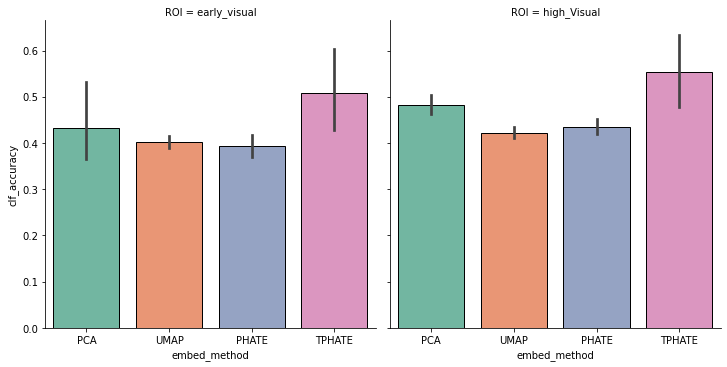

In [27]:
sns.catplot(x='embed_method', y='clf_accuracy', 
            data=df, col='ROI', kind='bar', order=['PCA','UMAP','PHATE','TPHATE'],
            palette='Set2', edgecolor='black')

In [3]:
df = pd.read_csv('../results/SVC_localizer_results.csv',index_col=0)
df.groupby(['embed_method','ROI']).mean()

subject  embedding_dimensions  clf_accuracy  \
embed_method ROI                                                         
ISOMAP       early_visual       11                    20      0.397550   
             high_Visual        11                    20      0.432692   
LLE          early_visual       11                    20      0.370994   
             high_Visual        11                    20      0.403617   
PHATE_TIME   early_visual       11                    20      0.379922   
             high_Visual        11                    20      0.379006   
SMOOTH_PHATE early_visual       11                    20      0.422505   
             high_Visual        11                    20      0.484432   
TPHATE       early_visual       11                    20      0.507898   
             high_Visual        11                    20      0.552770   

                             clf_sd  
embed_method ROI                     
ISOMAP       early_visual  0.028785  
             high_Visual   0.029962  
LLE          early_visual  0.033130  
             high_Visual   0.030665  
PHATE_TIME   early_visual  0.004694  
             high_Visual   0.006928  
SMOOTH_PHATE early_visual  0.031924  
             high_Visual   0.036395  
TPHATE       early_visual  0.048500  
             high_Visual   0.042699

In [20]:
df = pd.read_csv('../results/SVC_localizer_results.csv',index_col=0)
df['dataset']=['forrest' for i in range(len(df))]

stats_df = pd.DataFrame(columns = ['ROI', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

# barplot_all_methods(df, 'forrest', 'clf_accuracy', '../plots/localizer_clf_main.pdf', 
#                             ['PHATE_TIME', 'SMOOTH_PHATE',  'TPHATE'], ROIs=['early_visual','high_Visual'],
#                             ylim=[0,0.7])

for ROI in ['early_visual','high_Visual']:
    df_here2 = df[df['ROI']==ROI]
    n_tests = 2
    tphate_vals = df_here2[df_here2['embed_method']=='TPHATE']['clf_accuracy'].values
    for other_method in ['PHATE_TIME', 'SMOOTH_PHATE']:
        other_vals = df_here2[df_here2['embed_method']==other_method]['clf_accuracy'].values
        observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
        corrected = mystats.correct_pvalue(pval, n_tests)
        stats_df.loc[len(stats_df)] = {'ROI':ROI, 'comparison':f'TPHATE_v_{other_method}', 
                                      'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                      'pvalue_corrected':corrected}
        print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
        
# barplot_all_methods(df, 'forrest', 'clf_accuracy', '../plots/localizer_clf_supp.pdf', 
#                             ['ISOMAP',"LLE", 'TSNE',  'TPHATE'], ROIs=['early_visual','high_Visual'],
#                             ylim=[0,0.7])

for ROI in ['early_visual','high_Visual']:
    df_here2 = df[df['ROI']==ROI]
    n_tests = 2
    tphate_vals = df_here2[df_here2['embed_method']=='TPHATE']['clf_accuracy'].values
    for other_method in ['ISOMAP',"LLE"]:
        other_vals = df_here2[df_here2['embed_method']==other_method]['clf_accuracy'].values
        try:
            observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
        except:
            print(f'failed on {other_method}')
        corrected = mystats.correct_pvalue(pval, n_tests)
        stats_df.loc[len(stats_df)] = {'ROI':ROI, 'comparison':f'TPHATE_v_{other_method}', 
                                      'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                      'pvalue_corrected':corrected}
        print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')

        

early_visual sherlock PHATE_TIME avg_difference pc=0.016 pu=0.008
early_visual sherlock SMOOTH_PHATE avg_difference pc=0.006 pu=0.003
high_Visual sherlock PHATE_TIME avg_difference pc=0.004 pu=0.002
high_Visual sherlock SMOOTH_PHATE avg_difference pc=0.002 pu=0.001
early_visual sherlock ISOMAP avg_difference pc=0.002 pu=0.001
early_visual sherlock LLE avg_difference pc=0.002 pu=0.001
high_Visual sherlock ISOMAP avg_difference pc=0.002 pu=0.001
high_Visual sherlock LLE avg_difference pc=0.002 pu=0.001


## Figure 3 plots

In [50]:
## Time validation plots
dn = os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data')
af = np.load(dn+'/aud_early/embeddings/sub-10_aud_early_sherlock_movie_2dimension_embedding_TPHATE.npy')
bf = np.load(dn+'/aud_early/embeddings/sub-01_aud_early_sherlock_movie_2dimension_embedding_SMOOTH_PHATE.npy')
cf = np.load(dn+'/aud_early/embeddings/sub-10_aud_early_sherlock_movie_2dimension_embedding_PHATE_TIME.npy')

df = np.load(dn+'/high_Visual/embeddings/sub-10_high_Visual_sherlock_movie_2dimension_embedding_TPHATE.npy')
ef = np.load(dn+'/high_Visual/embeddings//sub-10_high_Visual_sherlock_movie_2dimension_embedding_SMOOTH_PHATE.npy')
ff = np.load(dn+'/high_Visual/embeddings//sub-10_high_Visual_sherlock_movie_2dimension_embedding_PHATE_TIME.npy')


sns.set(context='paper',style='white')
fig,ax=plt.subplots(3,1,figsize=(4,12))
scprep.plot.scatter2d(ff, ticks=False,c=np.arange(1976),legend=False,ax=ax[0])
scprep.plot.scatter2d(ef, ticks=False,c=np.arange(1976),legend=False,ax=ax[1])
scprep.plot.scatter2d(df, ticks=False,c=np.arange(1976),legend=False,ax=ax[2])
for a, label in zip(ax, ['PHATE+Time','Smooth PHATE','T-PHATE']):
    a.set_ylabel(label, fontsize=20)

plt.savefig('../plots/high_visual_time_method_scatter.pdf', bbox_inches = "tight",transparent=True, format='pdf')
plt.clf()

sns.set(context='paper',style='white')
fig,ax=plt.subplots(3,1,figsize=(4,12))
scprep.plot.scatter2d(cf, ticks=False,c=np.arange(1976),legend=False,ax=ax[0])
scprep.plot.scatter2d(bf, ticks=False,c=np.arange(1976),legend=False,ax=ax[1])
scprep.plot.scatter2d(af, ticks=False,c=np.arange(1976),legend=False,ax=ax[2])
for a, label in zip(ax, ['PHATE+Time','Smooth PHATE','T-PHATE']):
    a.set_ylabel(label, fontsize=20)

plt.savefig('../plots/aud_early_time_method_scatter.pdf', bbox_inches = "tight",transparent=True, format='pdf')
plt.clf()

<Figure size 288x864 with 0 Axes>

<Figure size 288x864 with 0 Axes>

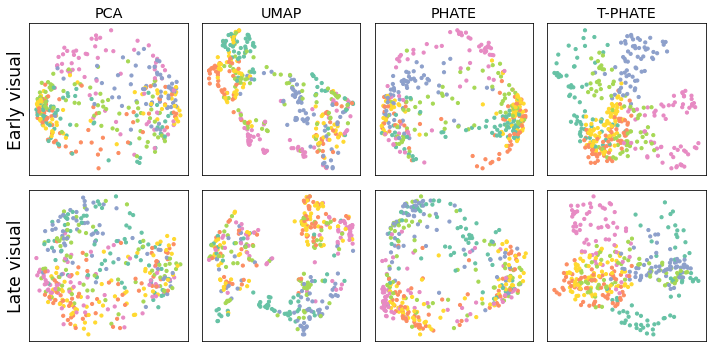

In [15]:
fig, ax = plt.subplots(2,4,figsize=(10,5))

# sub2_hv = utils.load_forrest_localizer_ROI_data('high_Visual',[2])[0]
# sub2_ev = utils.load_forrest_localizer_ROI_data('early_visual',[2])[0]

# labels = utils.load_forrest_localizer_labels(2)
# cmap ='Accent'

# embeddings = {}

# methods = ['TPHATE','PHATE','UMAP','PCA']
# for m in methods:
#     func = mf.func_dict[m]
#     embeddings[f'evis_{m}'] = func(sub2_ev, 2)
#     embeddings[f'hvis_{m}'] = func(sub2_hv, 2)

titles = ['PCA','UMAP','PHATE','T-PHATE']
for j,m in enumerate(['PCA','UMAP','PHATE','TPHATE']):
    for i,roi in enumerate(['evis','hvis']):
        key = f'{roi}_{m}'
        dat = embeddings[key]
        dat = dat[labels != -1]
        scprep.plot.scatter2d(dat, ax=ax[i][j], ticks=False, c=labels[labels != -1], cmap='Set2',legend=False)
        if i == 0:
            ax[i][j].set_title(titles[j], fontsize="x-large")
        if j == 0:
            ROIs = ['Early visual','Late visual']
            ax[i][j].set_ylabel(ROIs[i], fontsize="xx-large")

fig.tight_layout()
# plt.savefig('../plots/localizer_scatterplots.pdf', bbox_inches = "tight",transparent=True, format='pdf')
# plt.clf()

NameError: name 'utils' is not defined

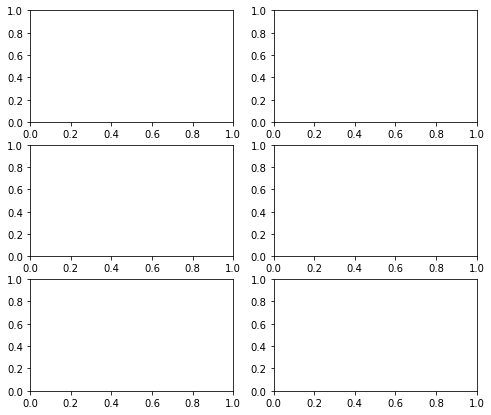

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(8,7))

sub2_hv = utils.load_forrest_localizer_ROI_data('high_Visual',[2])[0]
sub2_ev = utils.load_forrest_localizer_ROI_data('early_visual',[2])[0]

labels = utils.load_forrest_localizer_labels(2)
cmap ='Accent'

embeddings = {}

methods = ['TPHATE','PHATE_TIME','SMOOTH_PHATE','PHATE','UMAP','PCA']
for m in methods:
    func = mf.func_dict[m]
    embeddings[f'evis_{m}'] = func(sub2_ev, 2)
    embeddings[f'hvis_{m}'] = func(sub2_hv, 2)

titles = ['PHATE+Time','Smooth PHATE','T-PHATE']
for j,m in enumerate(['PHATE_TIME','SMOOTH_PHATE','TPHATE']):
    if m == 'ACPHATE':
        m='T-PHATE'
    for i,roi in enumerate(['evis','hvis']):
        key = f'{roi}_{m}'
        dat = embeddings[key]
        dat = dat[labels != -1]
        scprep.plot.scatter2d(dat, ax=ax[j][i], ticks=False, c=labels[labels != -1], cmap='Set2',legend=False)
        if i == 0:
            ax[j][i].set_ylabel(titles[j], fontsize="x-large")
        if j == 0:
            ROIs = ['Early visual','High visual']
            ax[j][i].set_title(ROIs[i], fontsize="xx-large")

fig.tight_layout()
plt.savefig('../plots/localizer_scatterplots.pdf', bbox_inches = "tight",transparent=True, format='pdf')
plt.clf()

## within subject HMM results - optimized M

In [11]:
df = pd.read_csv("../results/within_sub_neural_event_WB_tempBalance_results_compact.csv")

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindex

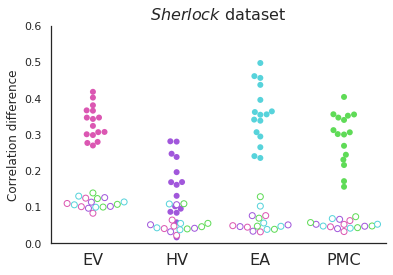

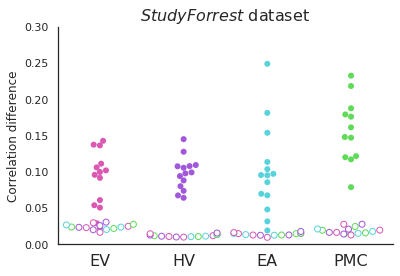

In [91]:
colors = config.edge_colors
fig,ax=plt.subplots(figsize=(6,4))
sns.set(style='white')
sub_df=df[df['embed_method'].isin(['voxel','TPHATE'])]

g=sns.swarmplot(data=sub_df[(sub_df['dataset']=='sherlock')&(df['embed_method']=='TPHATE')], 
              x='ROI', 
              y='avg_difference', 
             order = config.ROIs,
             palette = colors,
             size=6)

g=sns.swarmplot(data=sub_df[(sub_df['dataset']=='sherlock')&(df['embed_method']=='voxel')], 
              x='ROI', 
              y='avg_difference', 
             order = config.ROIs,
             color = 'white',
             size=6, 
             edgecolor=colors,
             linewidth=1, ax=ax)


sns.despine(top=True, right=True)
ax.legend([],[], frameon=False)
g.set_title("$\it{Sherlock}$ dataset",fontsize=16)
g.set( ylabel="Correlation difference", ylim=[0, 0.6], xlabel="")
g.set_xticklabels(['EV', 'HV','EA','PMC'],fontsize=16)
plt.savefig("../plots/sherlock_within_swarm.pdf", bbox_inches = "tight",transparent=True, format='pdf')


fig,ax=plt.subplots(figsize=(6,4))
sns.set(style='white')
g=sns.swarmplot(data=sub_df[(sub_df['dataset']=='forrest')&(df['embed_method']=='TPHATE')], 
              x='ROI', 
              y='avg_difference', 
             order = config.ROIs,
             palette = colors,
             size=6)

g=sns.swarmplot(data=sub_df[(sub_df['dataset']=='forrest')&(df['embed_method']=='voxel')], 
              x='ROI', 
              y='avg_difference', 
             order = config.ROIs,
             color = 'white',
             size=6, 
             edgecolor=colors,
             linewidth=1, ax=ax)
sns.despine(top=True, right=True)
g.set_title("$\it{StudyForrest}$ dataset",fontsize=16)
g.set( ylabel="Correlation difference", ylim=[0, 0.3], xlabel="")
g.set_xticklabels(['EV', 'HV','EA','PMC'],fontsize=16)
ax.legend([],[], frameon=False)

plt.savefig("../plots/forrest_within_swarm.pdf", bbox_inches = "tight",transparent=True, format='pdf')



In [14]:
df=df[['subject','ROI','dataset','avg_difference','CV_M','CV_K','embed_method','neg_LL','model_LogLikelihood','AIC']]
df.head()

,subject,ROI,dataset,avg_difference,CV_M,CV_K,embed_method,model_LogLikelihood,AIC,neg_LL
0,1,pmc_nn,sherlock,0.107371,3,25,ISOMAP,-2831.984417,7011.968833,2831.984417
1,2,pmc_nn,sherlock,0.069220,3,22,ISOMAP,-2861.997987,6777.995975,2861.997987
2,3,pmc_nn,sherlock,0.086312,3,21,ISOMAP,-2846.593722,6657.187444,2846.593722
3,4,pmc_nn,sherlock,0.117806,3,24,ISOMAP,-2846.153761,6938.307522,2846.153761
4,5,pmc_nn,sherlock,0.089996,3,23,ISOMAP,-2884.049689,6916.099379,2884.049689


In [37]:
for i in df.index:
    if np.isnan(df.iloc[i]['AIC']):
        K = df.iloc[i]['CV_K']
        ll = df.iloc[i]['model_LogLikelihood']
        a = -2 * ll + 2*(K**2 +2*K - 1)
        df.at[i, 'AIC'] = a
    

In [12]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'avg_difference':(0,0.5), 'AIC':(4000, 12000), 'neg_LL':(1600,3800)}, 
         'forrest': {'avg_difference':(0,0.25), 'AIC':(18000, 40000), 'neg_LL':(3300,7000)}}

for dataset in config.DATASETS:
    for yname in ['avg_difference','AIC','neg_LL']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/{dataset}_{yname}_within_subj_hmm_optimizeM.pdf'
        # barplot_all_methods(df_here, dataset, yname, fn, 
        #                     ["voxel",'PCA','UMAP','PHATE','TPHATE'], 
        #                     ROIs=ROIs_here, logscale=False, 
        #                    ylim=ranges[dataset][yname])
        
        # now do permutation tests
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 4
            for other_method in ["voxel",'PCA','UMAP','PHATE']:
                other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
#stats_df.to_csv("../results/within_subject_HMM_stats.csv")

early_visual sherlock voxel avg_difference pc=0.004 pu=0.001
early_visual sherlock PCA avg_difference pc=0.004 pu=0.001
early_visual sherlock UMAP avg_difference pc=0.004 pu=0.001
early_visual sherlock PHATE avg_difference pc=0.004 pu=0.001
high_Visual sherlock voxel avg_difference pc=0.004 pu=0.001
high_Visual sherlock PCA avg_difference pc=0.008 pu=0.002
high_Visual sherlock UMAP avg_difference pc=0.004 pu=0.001
high_Visual sherlock PHATE avg_difference pc=0.016 pu=0.004
aud_early sherlock voxel avg_difference pc=0.004 pu=0.001
aud_early sherlock PCA avg_difference pc=0.004 pu=0.001
aud_early sherlock UMAP avg_difference pc=0.004 pu=0.001
aud_early sherlock PHATE avg_difference pc=0.004 pu=0.001
pmc_nn sherlock voxel avg_difference pc=0.004 pu=0.001
pmc_nn sherlock PCA avg_difference pc=0.004 pu=0.001
pmc_nn sherlock UMAP avg_difference pc=0.004 pu=0.001
pmc_nn sherlock PHATE avg_difference pc=0.004 pu=0.001
early_visual sherlock voxel AIC pc=0.004 pu=0.001
early_visual sherlock PCA 

In [22]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'avg_difference':(0,0.5)}, 
         'forrest': {'avg_difference':(0,0.25)}}

for dataset in config.DATASETS:
    for yname in ['avg_difference']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/{dataset}_{yname}_within_subj_hmm_optimizeM_SUPP_TIME.pdf'
        barplot_all_methods(df_here, dataset, yname, fn, 
                            ["PHATE_TIME",'SMOOTH_PHATE','TPHATE'], 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 3
            for other_method in ["PHATE_TIME",'SMOOTH_PHATE']:
                other_vals = np.nan_to_num(df_here2[df_here2['embed_method']==other_method][yname].values)
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
stats_df.to_csv("../results/within_subject_SUPP_TIME_HMM_stats.csv")

early_visual sherlock PHATE_TIME avg_difference p=0.000333 observed=0.189113
early_visual sherlock SMOOTH_PHATE avg_difference p=0.038628 observed=0.050923
high_Visual sherlock PHATE_TIME avg_difference p=0.332667 observed=-0.112486
high_Visual sherlock SMOOTH_PHATE avg_difference p=0.327672 observed=-0.077687
aud_early sherlock PHATE_TIME avg_difference p=0.000333 observed=0.119446
aud_early sherlock SMOOTH_PHATE avg_difference p=0.000333 observed=0.117376
failed pmc_nn sherlock PHATE_TIME avg_difference
pmc_nn sherlock SMOOTH_PHATE avg_difference p=0.292041 observed=-0.037162
early_visual forrest PHATE_TIME avg_difference p=0.218115 observed=-0.005022
failed early_visual forrest SMOOTH_PHATE avg_difference
failed high_Visual forrest PHATE_TIME avg_difference
high_Visual forrest SMOOTH_PHATE avg_difference p=0.195804 observed=-0.004958
aud_early forrest PHATE_TIME avg_difference p=0.048618 observed=0.024247
aud_early forrest SMOOTH_PHATE avg_difference p=0.054279 observed=0.018418
pmc

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [42]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'avg_difference':(0,0.5)}, 
         'forrest': {'avg_difference':(0,0.25)}}

for dataset in config.DATASETS:
    for yname in ['avg_difference']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/{dataset}_{yname}_within_subj_hmm_optimizeM_SUPP.pdf'
        barplot_all_methods(df_here, dataset, yname, fn, 
                            ["ISOMAP",'LLE',"TSNE",'TPHATE'], 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 3
            for other_method in ["ISOMAP",'LLE',"TSNE"]:
                other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
stats_df.to_csv("../results/within_subject_supp_HMM_stats.csv")

early_visual sherlock ISOMAP avg_difference p=0.000333 observed=0.158192
early_visual sherlock LLE avg_difference p=0.000333 observed=0.183421
early_visual sherlock TSNE avg_difference p=0.000333 observed=0.171552
high_Visual sherlock ISOMAP avg_difference p=0.000666 observed=0.073834
high_Visual sherlock LLE avg_difference p=0.000333 observed=0.091928
high_Visual sherlock TSNE avg_difference p=0.010323 observed=0.027797
aud_early sherlock ISOMAP avg_difference p=0.000333 observed=0.239889
aud_early sherlock LLE avg_difference p=0.000333 observed=0.279204
aud_early sherlock TSNE avg_difference p=0.000333 observed=0.242524
pmc_nn sherlock ISOMAP avg_difference p=0.000333 observed=0.191573
pmc_nn sherlock LLE avg_difference p=0.000333 observed=0.223113
pmc_nn sherlock TSNE avg_difference p=0.000333 observed=0.193785
early_visual forrest ISOMAP avg_difference p=0.000666 observed=0.031832
early_visual forrest LLE avg_difference p=0.000333 observed=0.053182
early_visual forrest TSNE avg_dif

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [51]:
# plot M
for dataset in config.DATASETS:
    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_hmm_optimizeM.pdf'
    barplot_all_methods(df_here, dataset, "CV_M", fn, 
                        ['PCA', 'ISOMAP',"LLE","UMAP","PHATE",'SMOOTH_PHATE','PHATE_TIME','TPHATE'], 
                        ROIs=ROIs_here, logscale=False)

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [58]:
df_here = df[['ROI','dataset','embed_method','CV_M']].groupby(['embed_method','ROI','dataset']).mean().reset_index()
sd = df[['ROI','dataset','embed_method','CV_M']].groupby(['ROI','dataset','embed_method']).std().reset_index()['CV_M'].values
df_here['M s.d.'] = sd
df_here.rename({'CV_M':"M mean"},axis=1, inplace=True)
df_here = df_here[df_here['embed_method']!='voxel']
df_here

,embed_method,ROI,dataset,M mean,M s.d.
0,ISOMAP,aud_early,forrest,5.357143,1.081818
1,ISOMAP,aud_early,sherlock,3.000000,0.363137
2,ISOMAP,early_visual,forrest,3.000000,0.000000
3,ISOMAP,early_visual,sherlock,3.000000,0.497245
4,ISOMAP,high_Visual,forrest,3.714286,0.000000
...,...,...,...,...,...
67,UMAP,early_visual,sherlock,3.000000,0.000000
68,UMAP,high_Visual,forrest,10.000000,0.000000
69,UMAP,high_Visual,sherlock,3.937500,0.000000
70,UMAP,pmc_nn,forrest,3.000000,0.000000


In [ ]:
## within-subject HMM results - control M
df = pd.read_csv("../results/within_sub_neural_event_WB_tempBalance_results_controlM.csv")
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])



## compare control results and optimized results

In [39]:
df = pd.read_csv("../results/within_sub_neural_event_WB_tempBalance_results_controlM.csv")
df1 = pd.read_csv("../results/within_sub_neural_event_WB_tempBalance_results.csv")

In [41]:
df1 = df1[df1['embed_method']!='voxel']
df.shape, df1.shape

((1080, 10), (1080, 14))

In [44]:
df.sort_values(by=['dataset','ROI','embed_method','subject'],inplace=True)
df1.sort_values(by=['dataset','ROI','embed_method','subject'],inplace=True)
    

In [48]:
print("control vs optimized M WvB: ", stats.spearmanr(df['avg_difference'].values,df1['avg_difference'].values))
print("control vs optimized M AIC: ", stats.spearmanr(df['AIC'].values,df1['AIC'].values))
print("control vs optimized M LL: ", stats.spearmanr(df['model_LogLikelihood'].values,df1['model_LogLikelihood'].values))


control vs optimized M WvB:  SpearmanrResult(correlation=0.9451708110937069, pvalue=0.0)
control vs optimized M AIC:  SpearmanrResult(correlation=0.9915885082587043, pvalue=0.0)
control vs optimized M LL:  SpearmanrResult(correlation=0.9565886306677407, pvalue=0.0)


## within subject HMM results - control M

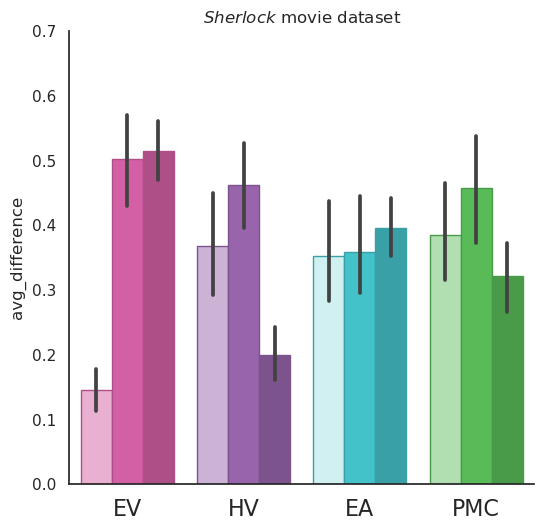

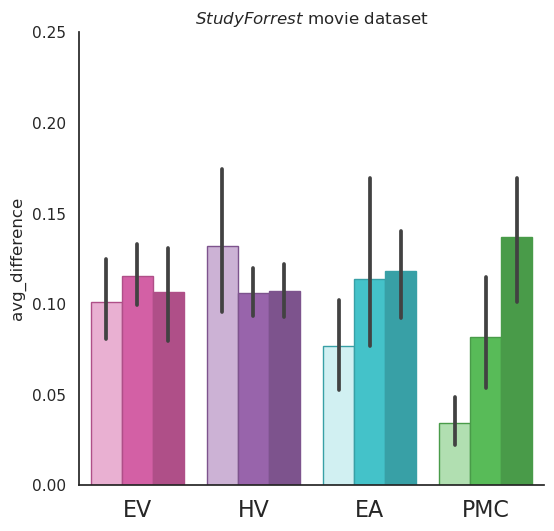

In [10]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'avg_difference':(0,0.7), 'AIC':(3000, 11000), 'neg_LL':(1300,3300)}, 
         'forrest': {'avg_difference':(0,0.25), 'AIC':(15000, 40000), 'neg_LL':(2700,6000)}}

for dataset in config.DATASETS:
    for yname in ['avg_difference']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/{dataset}_{yname}_within_subj_hmm_controlM_supp_time.pdf'
        g = barplot_all_methods(df_here, dataset, yname, None, 
                            ['PHATE_TIME','SMOOTH_PHATE',
                             'TPHATE'], 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])

In [15]:
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'avg_difference':(0,0.7), 'AIC':(3000, 11000), 'neg_LL':(1300,3300)}, 
         'forrest': {'avg_difference':(0,0.25), 'AIC':(15000, 40000), 'neg_LL':(2700,6000)}}
df = pd.read_csv("../results/within_sub_neural_event_WB_tempBalance_results_controlM.csv")

for dataset in config.DATASETS:
    for yname in ['AIC','neg_LL','avg_difference']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/{dataset}_{yname}_within_subj_hmm_controlM.pdf'
        # g = barplot_all_methods(df_here, dataset, yname, fn, 
        #                     ['PCA','UMAP','PHATE','TPHATE'], 
        #                     ROIs=ROIs_here, logscale=False, 
        #                    ylim=ranges[dataset][yname])
        # now do permutation tests
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 3
            for other_method in ['PCA','UMAP','PHATE']:
                other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/within_subject_HMM_stats_controlM.csv")

early_visual sherlock PCA AIC pc=0.003 pu=0.001
early_visual sherlock UMAP AIC pc=0.003 pu=0.001
early_visual sherlock PHATE AIC pc=0.003 pu=0.001
high_Visual sherlock PCA AIC pc=0.003 pu=0.001
high_Visual sherlock UMAP AIC pc=2.353 pu=0.784
high_Visual sherlock PHATE AIC pc=0.003 pu=0.001
aud_early sherlock PCA AIC pc=0.003 pu=0.001
aud_early sherlock UMAP AIC pc=0.03 pu=0.01
aud_early sherlock PHATE AIC pc=0.003 pu=0.001
pmc_nn sherlock PCA AIC pc=0.003 pu=0.001
pmc_nn sherlock UMAP AIC pc=0.315 pu=0.105
pmc_nn sherlock PHATE AIC pc=0.003 pu=0.001
early_visual sherlock PCA neg_LL pc=0.003 pu=0.001
early_visual sherlock UMAP neg_LL pc=0.003 pu=0.001
early_visual sherlock PHATE neg_LL pc=0.003 pu=0.001
high_Visual sherlock PCA neg_LL pc=0.003 pu=0.001
high_Visual sherlock UMAP neg_LL pc=2.311 pu=0.77
high_Visual sherlock PHATE neg_LL pc=0.003 pu=0.001
aud_early sherlock PCA neg_LL pc=0.003 pu=0.001
aud_early sherlock UMAP neg_LL pc=0.036 pu=0.012
aud_early sherlock PHATE neg_LL pc=0.00

## Behavioral event boundaries

In [18]:
df=pd.concat([pd.read_csv(f) for f in glob.glob('../results/source/*behavior*_control*.csv')])

df['dataset']=['sherlock' for i in range(len(df))]
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
for dataset in ['sherlock']:
    yname = 'avg_difference'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yname}_behav_controlM.pdf'
    # barplot_all_methods(df_here, dataset, yname, fn, 
    #                     ['PCA','UMAP','PHATE','TPHATE'], 
    #                     ROIs=ROIs_here, logscale=logsc, ylim=[-0.02, 0.09], yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 3
        for other_method in ['PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/behavioral_boundaries_stats_controlM.csv")


early_visual sherlock PCA avg_difference pc=0.309 pu=0.103
early_visual sherlock UMAP avg_difference pc=0.288 pu=0.096
early_visual sherlock PHATE avg_difference pc=0.348 pu=0.116
high_Visual sherlock PCA avg_difference pc=0.521 pu=0.174
high_Visual sherlock UMAP avg_difference pc=0.827 pu=0.276
high_Visual sherlock PHATE avg_difference pc=0.662 pu=0.221
aud_early sherlock PCA avg_difference pc=0.141 pu=0.047
aud_early sherlock UMAP avg_difference pc=0.396 pu=0.132
aud_early sherlock PHATE avg_difference pc=0.141 pu=0.047
pmc_nn sherlock PCA avg_difference pc=0.012 pu=0.004
pmc_nn sherlock UMAP avg_difference pc=0.003 pu=0.001
pmc_nn sherlock PHATE avg_difference pc=0.006 pu=0.002


In [19]:
df=pd.read_csv('../results/behavioral_event_WB_tempBalance_results.csv')

df['dataset']=['sherlock' for i in range(len(df))]
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
for dataset in ['sherlock']:
    yname = 'avg_difference'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yname}_behav.pdf'
    barplot_all_methods(df_here, dataset, yname, fn, 
                        ['voxel','PCA','UMAP','PHATE','TPHATE'], 
                        ROIs=ROIs_here, logscale=logsc, ylim=[-0.02, 0.1], yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 4
        for other_method in ['voxel','PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
#stats_df.to_csv("../results/behavioral_boundaries_stats.csv")


early_visual sherlock voxel avg_difference pc=0.016 pu=0.004
early_visual sherlock PCA avg_difference pc=0.012 pu=0.003
early_visual sherlock UMAP avg_difference pc=0.012 pu=0.003
early_visual sherlock PHATE avg_difference pc=0.02 pu=0.005
high_Visual sherlock voxel avg_difference pc=0.444 pu=0.111
high_Visual sherlock PCA avg_difference pc=0.328 pu=0.082
high_Visual sherlock UMAP avg_difference pc=0.595 pu=0.149
high_Visual sherlock PHATE avg_difference pc=0.404 pu=0.101
aud_early sherlock voxel avg_difference pc=0.392 pu=0.098
aud_early sherlock PCA avg_difference pc=0.356 pu=0.089
aud_early sherlock UMAP avg_difference pc=0.891 pu=0.223
aud_early sherlock PHATE avg_difference pc=0.38 pu=0.095
pmc_nn sherlock voxel avg_difference pc=0.004 pu=0.001
pmc_nn sherlock PCA avg_difference pc=0.008 pu=0.002
pmc_nn sherlock UMAP avg_difference pc=0.004 pu=0.001
pmc_nn sherlock PHATE avg_difference pc=0.004 pu=0.001


<Figure size 600x600 with 0 Axes>

In [43]:
df=pd.read_csv('../results/behavioral_event_WB_tempBalance_results.csv')

df['dataset']=['sherlock' for i in range(len(df))]
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
for dataset in ['sherlock']:
    yname = 'avg_difference'
    logsc=False
    alt='greater'

    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/{dataset}_{yname}_supp_behav.pdf'
    barplot_all_methods(df_here, dataset, yname, fn, 
                        ["ISOMAP",'LLE',"TSNE",'TPHATE'], 
                        ROIs=ROIs_here, logscale=logsc, ylim=[-0.02, 0.1], yax=True)

    # now do permutation tests
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 4
        for other_method in ["ISOMAP",'LLE',"TSNE"]:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            try:
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            except:
                print(f'failed {ROI} {dataset} {other_method} {yname}')
                continue
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            # print(f'{ROI} {dataset} {other_method} {yname} p={corrected:03f} observed={observed:03f}')
stats_df.to_csv("../results/behavioral_boundaries_supp_stats.csv")


<Figure size 600x600 with 0 Axes>

## event boundaries

In [9]:
df = pd.read_csv("../results/behavioral_event_WB_tempBalance_results.csv")
df[(df['subject']==15)&(df['ROI'] == 'pmc_nn')]#== df['avg_difference'].max()]

,Unnamed: 0,Unnamed: 0.1,subject,embed_method,CV_M,avg_within,avg_between,avg_difference,ROI
494,14,14,15,PHATE,3,-0.007077,-0.003752,-0.003325,pmc_nn
510,30,30,15,TPHATE,4,0.251907,0.098993,0.152914,pmc_nn
526,46,46,15,UMAP,5,0.689614,0.677872,0.011742,pmc_nn
542,62,62,15,PCA,3,-0.017368,-0.001961,-0.015407,pmc_nn
558,78,78,15,LLE,3,0.011162,0.014180,-0.003018,pmc_nn
574,94,94,15,ISOMAP,3,-0.008172,0.000179,-0.008351,pmc_nn
590,110,110,15,SMOOTH_PHATE,3,0.106528,0.358067,-0.251539,pmc_nn
606,126,126,15,PHATE_TIME,3,0.666348,0.691659,-0.025311,pmc_nn
622,142,142,15,TSNE,3,-0.004804,-0.011721,0.006917,pmc_nn
638,158,158,15,voxel,481,-0.006936,-0.014582,0.007646,pmc_nn


In [2]:

def get_scene_boundaries():
    sherlock_scenes_labels = utils.load_coded_regressors('sherlock', 'SceneTitleCoded')
    sherlock_scene_boundaries = [1] + list(np.where(np.diff(sherlock_scenes_labels))[0]) + [len(sherlock_scenes_labels)]
    return sherlock_scene_boundaries


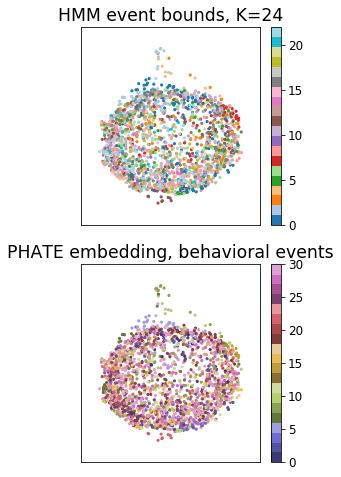

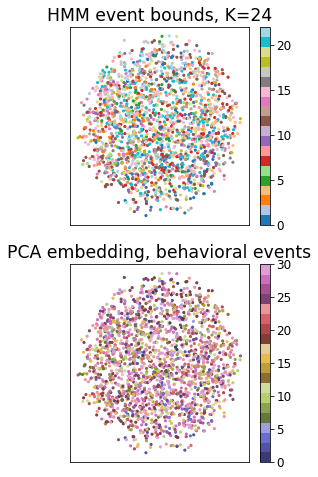

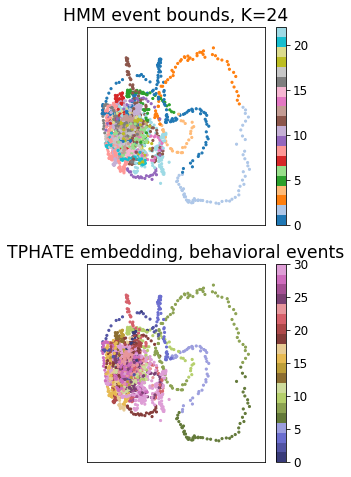

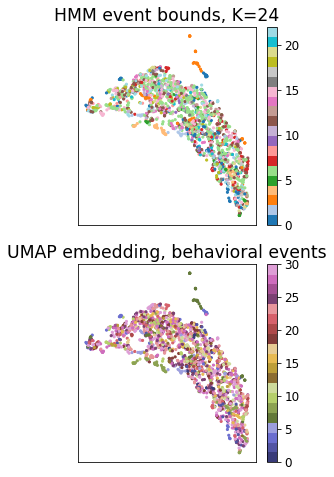

In [45]:
behav_boundaries = np.array(utils.get_scene_boundaries())
behav_labels=expand_boundary_labels(behav_boundaries, 1976)
behav_bounds_cropped = behav_boundaries[behav_boundaries > 1000] - 1000
K_behav = len(behav_boundaries)-1

for roi in ['pmc_nn']:
    for meth in ['PHATE','PCA','TPHATE','UMAP']:
        s=15
        fn=glob.glob(f'../intermediate_data/HMM_learnK_nested/sub-{s:02d}*{roi}*sherlock*dimension*{meth}*HMM_boundaries.npy')[0]

        M = int(fn.split('dimension')[0].split('/')[-1].split('movie_')[-1])
        HMM_bounds = np.load(fn)
        K = len(HMM_bounds)
        data = np.load(os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data',roi, 
                             'embeddings',f'sub-{s:02d}_{roi}_sherlock_movie_{M}dimension_embedding_{meth}.npy'))
        # crop the bounds
        event_labels = np.array(expand_boundary_labels(HMM_bounds, 1976))
        K_HMM = len(HMM_bounds)-1
        HMM_bounds_cropped = HMM_bounds[HMM_bounds > 1000] - 1000

#         plot_bounds_corrmat(data, HMM_bounds, 
#                         second_bounds = behav_boundaries, alpha=0.5, 
#                         outfn=f'../plots/corrplot_{meth}_{roi}_sub-{s:02d}.pdf',
#                            edgecolor1=pmc_colors[-1], edgecolor2='yellow')

#         # load in data and visualize
        fig,ax=plt.subplots(2,1,figsize=(4, 8))
        b = np.load(os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data',roi, 
                                 'embeddings',f'sub-{s:02d}_{roi}_sherlock_movie_2dimension_embedding_{meth}.npy'))

        scprep.plot.scatter2d(b, ax=ax[0], c=event_labels, discrete=False, cmap='tab20',title=f"HMM event bounds, K={K}", ticks=False)
        scprep.plot.scatter2d(b,ax=ax[1], c=behav_labels, cmap='tab20b',title=f"{meth} embedding, behavioral events", ticks=False)
        outfn=f'../plots/scatter_event_bounds_{meth}_{roi}.pdf'
        plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')

    

In [129]:
data = utils.load_sherlock_movie_ROI_data('pmc_nn', subjects=[15], z=True)[0]
meth='voxel'
fn=glob.glob(f'../intermediate_data/HMM_learnK_nested/sub-{s:02d}*{roi}*sherlock*{meth}*HMM_boundaries.npy')[0]
HMM_bounds=np.load(fn)
plot_bounds_corrmat(data, HMM_bounds, 
                        second_bounds = behav_boundaries, alpha=0.5, 
                        outfn=f'../plots/corrplot_{meth}_{roi}_sub-{s:02d}.pdf',
                           edgecolor1=pmc_colors[-1], edgecolor2='yellow')

<Figure size 432x432 with 0 Axes>

In [26]:
from step_03_HMM_optimizeM_embeddings import expand_boundary_labels


In [75]:
s = 15
roi = 'pmc_nn'
M = 5
meth = 'UMAP'

a = np.load(os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data','pmc_nn', 
                         'embeddings',f'sub-{s:02d}_{roi}_sherlock_movie_{M}dimension_embedding_{meth}.npy'))
fn=glob.glob(f'../intermediate_data/HMM_learnK_nested/sub-{s}*{roi}*sherlock*{M}dimension*{meth}*HMM_boundaries.npy')[0]

behav_boundaries = np.array(utils.get_scene_boundaries())
behav_labels=expand_boundary_labels(behav_boundaries, 1976)


event_boundaries = np.load(fn)
event_labels = expand_boundary_labels(event_boundaries, 1976)
tphate_event_bounds_cropped = event_boundaries[event_boundaries > 1000] - 1000
behav_bounds_cropped = behav_boundaries[behav_boundaries > 1000] - 1000

plot_bounds_corrmat(a, event_boundaries, edgecolor1=pmc_colors[-1],
                    second_bounds = behav_boundaries, alpha=0.5, 
                    outfn='../plots/umap_pmc_sub15_optm.pdf')

# fig,ax=plt.subplots(1,2,figsize=(8,3))
# b = np.load(os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data','pmc_nn', 
#                          'embeddings',f'sub-{s:02d}_{roi}_sherlock_movie_2dimension_embedding_{meth}.npy'))

# scprep.plot.scatter2d(a, ax=ax[0], c=event_labels, cmap='Set2',title="HMM event bounds, K=22", ticks=False)
# scprep.plot.scatter2d(a, ax=ax[1], c=behav_labels, cmap='Paired',title="Behavioral event bounds, K=32", ticks=False)
# outfn='../plots/scatter_event_bounds_TPHATE.pdf'
# #plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')


# fig,ax=plt.subplots(1,2,figsize=(8,3))
# b = np.load(os.path.join(config.DATA_FOLDERS['sherlock'],'ROI_data','pmc_nn', 
#                          'embeddings',f'sub-{s:02d}_{roi}_sherlock_movie_2dimension_embedding_UMAP.npy'))
# outfn = '../plots/scatter_event_bounds_UMAP.pdf'
# scprep.plot.scatter2d(a, ax=ax[0], c=event_labels, cmap='gist_ncar',title="HMM event bounds, K=22", ticks=False)
# scprep.plot.scatter2d(a, ax=ax[1], c=behav_labels, cmap='gist_stern',title="Behavioral event bounds, K=32", ticks=False)



<Figure size 432x432 with 0 Axes>

In [23]:
def plot_bounds_corrmat(timeseries_data, boundaries, cmap='gray', alpha=1, 
                        edgecolor1='red', 
                        title=None, second_bounds=[], 
                        edgecolor2='yellow', axlabel=None, outfn=None):
    
    f, ax = plt.subplots(1,1, figsize=(6,6))    
    ax.grid(False)
    ax.imshow(
        np.corrcoef(timeseries_data), aspect='auto', cmap=cmap, vmin=-1, vmax=1,alpha=alpha
    )

    # these are the human rater boundaries
    if (boundaries[0] != 0):
        boundaries = np.concatenate(([0],boundaries))
    if (boundaries[-1] != len(timeseries_data)):
        boundaries = np.concatenate((boundaries,[len(timeseries_data)]))

    bounds_aug = boundaries
    for i in range(len(bounds_aug)-1):
        rect = patches.Rectangle(
            (bounds_aug[i],bounds_aug[i]),
            bounds_aug[i+1]-bounds_aug[i],
            bounds_aug[i+1]-bounds_aug[i],
            linewidth=2,ec=edgecolor1,facecolor='none'
        )
        ax.add_patch(rect)
        
    if len(second_bounds)>0: 
        if (second_bounds[0] != 0):
            second_bounds = np.concatenate(([0],second_bounds))
        if (second_bounds[-1] != len(timeseries_data)):
            second_bounds = np.concatenate((second_bounds,[len(timeseries_data)]))

        bounds_aug = second_bounds
        for i in range(len(bounds_aug)-1):
            rect = patches.Rectangle(
                (bounds_aug[i],bounds_aug[i]),
                bounds_aug[i+1]-bounds_aug[i],
                bounds_aug[i+1]-bounds_aug[i],
                linewidth=2,ec=edgecolor2,facecolor='none'
            )
            ax.add_patch(rect)
            
    ax.set(xlabel=axlabel,ylabel=axlabel,title=title)
    f.tight_layout()
    if outfn is not None:
        plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')
        plt.clf()
    else:
        return fig
        


In [48]:
buff_res = pd.read_csv("../results/human_bounds_behav_bounds_sameK_final.csv",index_col=0)
buff_res1 = pd.read_csv("../results/human_bounds_behav_bounds_sameK_final_CV_M.csv",index_col=0)
buff_res['M']=np.repeat(3, len(buff_res))
buff_res1['M']=np.repeat("CV", len(buff_res))

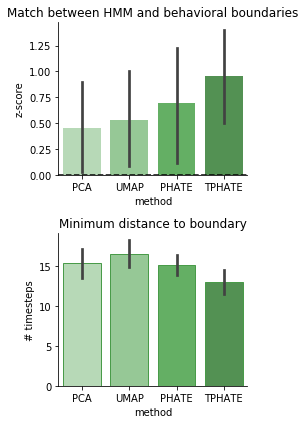

In [55]:
fig,ax=plt.subplots(2,1,figsize=(4,6))
g=sns.barplot(data=buff_res1, x='method', y='zscore', order = ['PCA','UMAP','PHATE','TPHATE'], 
              palette=pmc_colors[1:],  ax=ax[0])
g.axhline(0,linestyle='--',color='k')
g.set(title='Match between HMM and behavioral boundaries', ylabel='z-score')
g=sns.barplot(data=buff_res1, x='method', y='min_dist_med', order = ['PCA','UMAP','PHATE','TPHATE'], 
              palette=pmc_colors[1:], ax=ax[1],edgecolor=pmc_colors[-1])
g.set(title='Minimum distance to boundary', ylabel='# timesteps')
sns.despine(top=True, right=True)

fig.tight_layout()
plt.savefig('../plots/match_behav_CV_M.pdf', bbox_inches = "tight", transparent=True, format='pdf')